# Gaussian Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,3)

def load_data(path):
    temp_x = []
    temp_y = []
    for line in open(path):
        x, y = line.split(' ')
        temp_x.append(float(x))
        temp_y.append(float(y))

    return np.asarray(temp_x), np.asarray(temp_y)

x, y = load_data('input.data')

## 1. Kernel Function
$\widetilde{K}\left(x_{1}-x_{2}\right)=\sigma^{2}\left(1+\frac{\left(x_{1}-x_{2}\right)^{2}}{2 \alpha l^{2}}\right)^{-\alpha}$

In [2]:
def Rational_Quardratic_Kernel(x1, x2, sigma=1, alpha=1, length_scale=1):
    """
    # Input
        x1: data feature 1 (n,1)
        x2: data feature 2 (1,n)
        sigma: Kernel vertical variation
        alpha: Control length
        length_scale: Kernel length, larger smoother
        
    # Return
        kernel: data feature combination (n,n)
    """    
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(1, -1)
    d = (x1 - x2)**2 / (2*alpha*(length_scale**2))
    kernel = np.power((1 + d), -alpha) * sigma**2
    
    return kernel

## 2. Conditional
$\mathbf{C}\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right)+\beta^{-1} \delta_{n m}$


$\begin{aligned} \mu\left(\mathbf{x}^{*}\right) &=k\left(\mathbf{x}, \mathbf{x}^{*}\right)^{\top} \mathbf{C}^{-1} \mathbf{y} \\ \sigma^{2}\left(\mathbf{x}^{*}\right)=& k^{*}-k\left(\mathbf{x}, \mathbf{x}^{*}\right)^{\top} \mathbf{C}^{-1} k\left(\mathbf{x}, \mathbf{x}^{*}\right) \\ k^{*} &=k\left(\mathbf{x}^{*}, \mathbf{x}^{*}\right)+\beta^{-1} \end{aligned}$

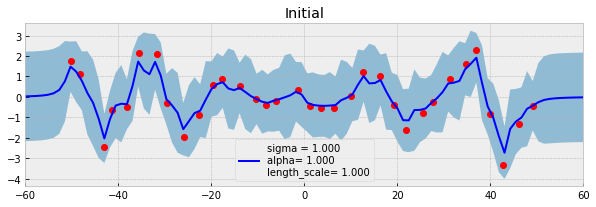

In [12]:
def Gaussian_Process(x, y, s, a, l):
    """
    # Input
        x: data feature
        y: label
        s: sigma (Kernel vertical variation)
        a: alpha (Control length)
        l: length_scale (Kernel length, larger smoother)
    """   
    beta = 5 # Noise, lower more noise, avoid overfitting
    k = Rational_Quardratic_Kernel(x, x, sigma=s, alpha=a, length_scale=l) # (34,34)
    C = k + (1/beta)*np.identity(len(k)) # (34,34)
    line = np.linspace(-60, 60, 100) # (100,)

    kx_kxstar = Rational_Quardratic_Kernel(x, line, sigma=s, alpha=a, length_scale=l) # (34, 100)
    kxstar_kxstar = Rational_Quardratic_Kernel(line, line, sigma=s, alpha=a, length_scale=l) # (100, 100)

    mu = kx_kxstar.T @ np.linalg.inv(C) @ y # (100,34) @ (34,34) @ (34,) = (100,)

    kstar = kxstar_kxstar + (1/beta) # (100,100)
    var = kstar - kx_kxstar.T @ np.linalg.inv(C) @ kx_kxstar # (100,34) @ (34,34) @ (34,100) = (100,100)
    var = np.sqrt(np.diag(var))

    # Visualization
    hyperparameter = f'sigma = {s:.3f}\nalpha= {a:.3f}\nlength_scale= {l:.3f}'
    plt.style.use('bmh')
    plt.plot(x, y, 'ro')
    plt.plot(line, mu, 'b-', label=hyperparameter)

    plt.fill_between(line, mu+2*var, mu-2*var, alpha=0.5)
    plt.xlim([-60, 60])
    plt.legend(loc=8)
    plt.show()
   
init_sigma = init_alpha = init_length_scale = 1
plt.title('Initial')
Gaussian_Process(x, y, init_sigma, init_alpha, init_length_scale)

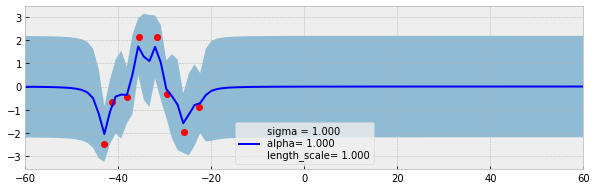

In [13]:
Gaussian_Process(x[2:10], y[2:10].reshape(-1,), init_sigma, init_alpha, init_length_scale)

## Experiment on Hyperparameters
$\widetilde{K}\left(x_{1}-x_{2}\right)=\sigma^{2}\left(1+\frac{\left(x_{1}-x_{2}\right)^{2}}{2 \alpha l^{2}}\right)^{-\alpha}$
### Sigma σ

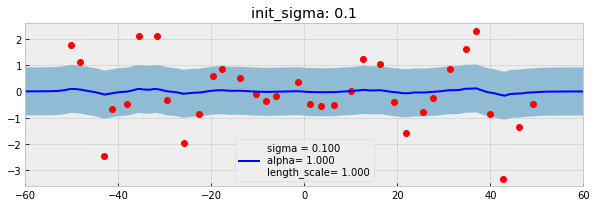

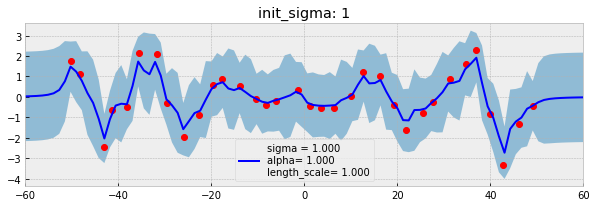

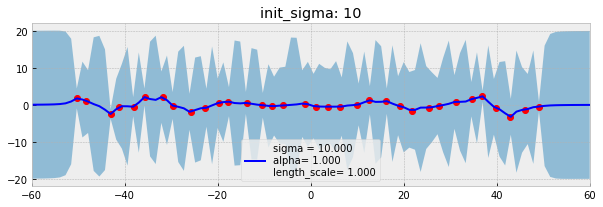

In [5]:
for i in [0.1, 1, 10]:
    plt.title(f'init_sigma: {i}')
    Gaussian_Process(x, y, i, init_alpha, init_length_scale)

### Alpha α

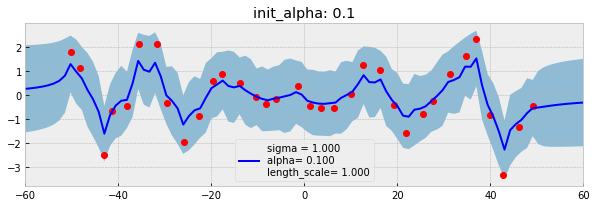

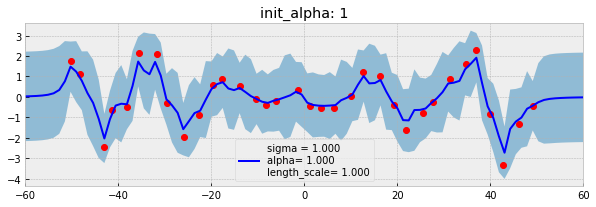

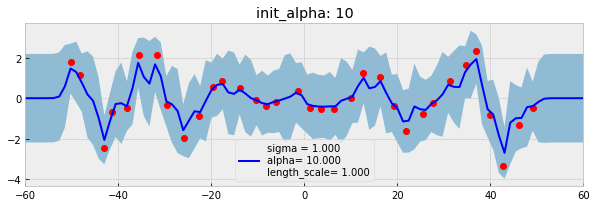

In [6]:
for i in [0.1, 1, 10]:
    plt.title(f'init_alpha: {i}')
    Gaussian_Process(x, y, init_sigma, i, init_length_scale)

### Length_scale l

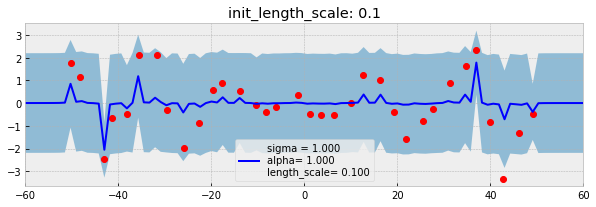

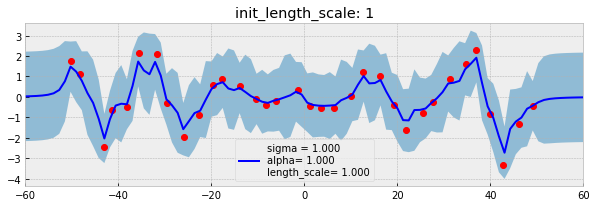

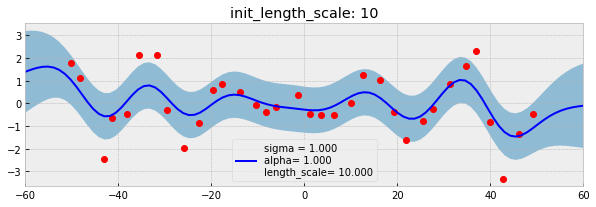

In [7]:
for i in [0.1, 1, 10]:
    plt.title(f'init_length_scale: {i}')
    Gaussian_Process(x, y, init_sigma, init_alpha, i)

## 3. Optimize the Kernel Parameters

$\operatorname{argmax}(\ln p(y | \theta))=-\frac{1}{2} \ln \left|C_{\theta}\right|-\frac{1}{2} y^{T} C_{\theta}^{-1}\mathbf{y}-\frac{N}{2} \ln (2 \pi)$
$\propto-\ln \left|C_{\theta}\right|-y^{T} C_{\theta}^{-1} y$


$=\operatorname{argmin}\left(\ln \left|C_{\theta}\right|+y^{T} C_{\theta}^{-1} y\right)$

In [8]:
from scipy.optimize import minimize

def objective_function(x, y, beta):
    """
    # Input
        x: data feature
        y: label
        beta: noise, lower more noise, avoid overfitting
    """   
    def objective(theta):
        """
        # Input
            theta: hyperparameters
        """
        k = Rational_Quardratic_Kernel(x, x, sigma=theta[0], alpha=theta[1], length_scale=theta[2])
        C = k + (1/beta)*np.identity(len(k))
        return np.log(np.linalg.det(C)) + y.T @ np.linalg.inv(C) @ y

    return objective

beta = 5

objective_value = np.inf
inits = [1e-2, 1e-1, 0, 1e1, 1e2]

for init_sigma in inits:
    for init_alpha in inits:
        for init_length_scale in inits:
            res = minimize(objective_function(x, y, beta), x0=[init_sigma, init_alpha, init_length_scale], bounds=((1e-5,None), (1e-5,None), (1e-5,None)))
            if res.fun < objective_value:
                objective_value = res.fun
                sigma_opt, alpha_opt, length_scale_opt = res.x

print('sigma: ', sigma_opt)
print('alpha: ',alpha_opt)
print('length_scale: ',length_scale_opt)

sigma:  1.3086673427082567
alpha:  2405.7146900275693
length_scale:  3.3260099629544553


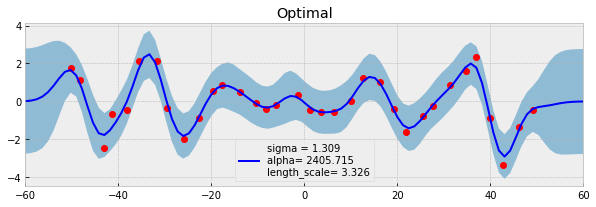

In [9]:
plt.title('Optimal')
Gaussian_Process(x, y, sigma_opt, alpha_opt, length_scale_opt)